In [1]:
import logging, uuid, time, csv

from kubernetes import client, config, watch

logging.basicConfig(level=logging.INFO)
config.load_kube_config("/home/goughes/k8s/configs/erikdev-admin.yaml")
core_api = client.CoreV1Api()
batch_api = client.BatchV1Api()

In [2]:
# based on https://medium.com/@aris.david/how-to-create-a-job-using-kubernetes-python-client-ed00ac2b791d
class Kubernetes:
    def __init__(self):

        # Init Kubernetes
        self.core_api = client.CoreV1Api()
        self.batch_api = client.BatchV1Api()

    def create_namespace(self, namespace):

        namespaces = self.core_api.list_namespace()
        all_namespaces = []
        for ns in namespaces.items:
            all_namespaces.append(ns.metadata.name)

        if namespace in all_namespaces:
            logging.info(f"Namespace {namespace} already exists. Reusing.")
        else:
            namespace_metadata = client.V1ObjectMeta(name=namespace)
            self.core_api.create_namespace(
                client.V1Namespace(metadata=namespace_metadata)
            )
            logging.info(f"Created namespace {namespace}.")

        return namespace

    @staticmethod
    def create_container(image, name, pull_policy, cpu_limit, mem_limit, sleep_time):

        resources = client.V1ResourceRequirements(
            requests={"cpu": cpu_limit, "memory": mem_limit},
            limits={"cpu": cpu_limit, "memory": mem_limit}
        )
            
        container = client.V1Container(
            image=image,
            name=name,
            resources=resources,
            image_pull_policy=pull_policy,
            args=[sleep_time],
            command=["sleep"],
        )

        logging.info(
            f"Created sleep container with name: {container.name}, "
            f"image: {container.image} and args: {container.args}"
        )

        return container

    @staticmethod
    def create_pod_template(pod_name, container):
        pod_template = client.V1PodTemplateSpec(
            spec=client.V1PodSpec(restart_policy="Never", containers=[container]),
            metadata=client.V1ObjectMeta(name=pod_name, labels={"pod_name": pod_name}),
        )

        return pod_template

    @staticmethod
    def create_job(job_name, pod_template):
        metadata = client.V1ObjectMeta(name=job_name, labels={"job_name": job_name})

        job = client.V1Job(
            api_version="batch/v1",
            kind="Job",
            metadata=metadata,
            spec=client.V1JobSpec(backoff_limit=0, template=pod_template),
        )

        return job
    
    @staticmethod
    def get_all_pods(namespace):
        pods = core_api.list_namespaced_pod(namespace, pretty=True, timeout_seconds=60)
        print("number of pods: " + str(len(pods.items)))
        return pods
    
    @staticmethod
    def get_all_jobs(namespace):
        jobs = batch_api.list_namespaced_job(namespace, pretty=True, timeout_seconds=60)
        print("number of jobs: " + str(len(jobs.items)))
        return jobs
    
    @staticmethod
    def delete_all_jobs(namespace):
        jobs = batch_api.list_namespaced_job(namespace, pretty=True, timeout_seconds=60)
        deleteoptions = client.V1DeleteOptions()
        for job in jobs.items:
            print("Deleting job " + job.metadata.name)
            jobname = job.metadata.name
            api_response = batch_api.delete_namespaced_job(jobname,
                                                           namespace,
                                                           grace_period_seconds=0, 
                                                           propagation_policy='Background')
            logging.debug(api_response)
    
    """
        interval: time to wait/sleep between each job submission
    """
    @staticmethod
    def submit_workflow(namespace, cpu_limit, mem_limit, total_jobs, sleep_time, interval):
        image = "busybox:1.36"
        name = "sleep-" + namespace
        pull_policy = "Never"

        jobs_submitted = 0
        while jobs_submitted < total_jobs:
            container = k8s.create_container(image, name, pull_policy, cpu_limit, mem_limit, sleep_time)

            pod_id = uuid.uuid4()
            job_id = pod_id
            # create template
            _pod_name = f"{namespace}-pod-{pod_id}"
            _pod_spec = k8s.create_pod_template(_pod_name, container)

            # create job
            _job_name = f"{namespace}-{job_id}"
            _job = k8s.create_job(_job_name, _pod_spec)

            # execute job
            batch_api = client.BatchV1Api()
            batch_api.create_namespaced_job(namespace, _job)
            jobs_submitted = jobs_submitted + 1
            time.sleep(interval)

In [3]:
k8s = Kubernetes()

namespaces = ["tenant1", "tenant2", "tenant3"]

# clean each namespace of any leftover jobs
for namespace in namespaces:
    k8s.delete_all_jobs(namespace)

# wait until all the pods are deleted before starting run
cleaned_up = False
while not cleaned_up:
    print("waiting for pod clean up...")
    all_pods = core_api.list_pod_for_all_namespaces()
    all_tenant_pods = [ pod for pod in all_pods.items if "tenant" in pod.metadata.name]
    if not all_tenant_pods:
        print("pods are cleaned up!")
        cleaned_up = True
    time.sleep(1)

# format of parameters list of lists
# params = [
#     [namespace1, cpu_limit, mem_limit, num_jobs, sleep_time, submission_interval],
#     [namespace2, cpu_limit, mem_limit, num_jobs, sleep_time, submission_interval],
# ]

params = [
    ["tenant1", "1", "2G", 1000, "60", 1], 
    ["tenant2", "1", "2G", 750, "60", 1.5],
    ["tenant3", "1", "2G", 500, "60", 2]
]

from multiprocess import Pool

def submit_parallel_workflows(params):
    namespace  = params[0]
    cpu_limit  = params[1]
    mem_limit  = params[2]
    num_jobs   = params[3]
    sleep_time = params[4]
    interval   = params[5]
    k8s.submit_workflow(namespace, cpu_limit, mem_limit, num_jobs, sleep_time, interval)

p = Pool(len(params))
result = p.map_async(submit_parallel_workflows, params)


Deleting job tenant1-002ce860-3724-457a-a40a-defbd9d28611
Deleting job tenant1-00338c02-77c9-491b-8102-bb16a78f2293
Deleting job tenant1-0050d6f2-5df2-451e-8c34-e708785b95ad
Deleting job tenant1-00cde621-8d09-4125-bf5a-64cb70ed6c3b
Deleting job tenant1-00e5d2c4-2976-4d2e-af7e-70215b81e401
Deleting job tenant1-0147fd96-62ce-4d5e-ab16-a47651874f62
Deleting job tenant1-014b33df-33de-4690-8c11-7e7591bcf72c
Deleting job tenant1-015fb1a5-26b8-46ee-8cf3-ac1ff81602b5
Deleting job tenant1-01bb3a3b-b300-4a94-992b-48fd374b180c
Deleting job tenant1-02eb4459-bafa-4153-ba8f-efc1ca1ac3d8
Deleting job tenant1-0363a439-44ca-44fa-8510-acdb6205f336
Deleting job tenant1-039c21f4-a145-4c8d-bafb-a582e6453305
Deleting job tenant1-03acc301-8a79-43ec-b610-3b935448d3c9
Deleting job tenant1-03dc6d78-d9be-4453-8173-f89f2e3ed619
Deleting job tenant1-03e6b2b7-6573-4c50-a6cc-3478e3db4932
Deleting job tenant1-0426a6ab-a746-4a6c-abd7-244043e5b0ab
Deleting job tenant1-042e1111-8ff7-4a9b-8a7e-fffafb08debf
Deleting job t

INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']
INFO:root:Created sleep container with name: sleep-tenant2, image: busybox:1.36 and args: ['60']
INFO:root:Created sleep container with name: sleep-tenant1, image: busybox:1.36 and args: ['60']
INFO:root:Created sleep container with name: sleep-tenant1, image: busybox:1.36 and args: ['60']
INFO:root:Created sleep container with name: sleep-tenant2, image: busybox:1.36 and args: ['60']
INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']
INFO:root:Created sleep container with name: sleep-tenant1, image: busybox:1.36 and args: ['60']
INFO:root:Created sleep container with name: sleep-tenant2, image: busybox:1.36 and args: ['60']
INFO:root:Created sleep container with name: sleep-tenant1, image: busybox:1.36 and args: ['60']
INFO:root:Created sleep container with name: sleep-tenant3, image: busybox:1.36 and args: ['60']
INFO:root:Created sleep contai


### Dictionary format used to store experiment data

Assuming `namespaces = ["tenant1", "tenant2", "tenant3"]` the dictionary would be created as follows:
```
data = {
    'timestamp':[1,2,3,4,5],
    'tenant1_pending':[3,4,3,4,5],
    'tenant1_running':[5,6,5,6,5],
    'tenant1_completed':[7,6,7,8,7],
    'tenant2_pending':[1,1,1,1,1],
    'tenant2_running':[2,2,2,2,2],
    'tenant2_completed':[3,3,3,3,3],
    'tenant3_pending':[2,3,2,3,2],
    'tenant3_running':[3,4,3,4,3],
    'tenant3_completed':[5,5,5,5,5],
}
```

In [4]:
import pprint

# returns total pending/running/completed cores across all namespaces
def get_totals(namespaces):
    total_running = 0
    total_pending = 0
    total_completed = 0
    for namespace in namespaces:
        if not exp_data[namespace+'_pending'] or not exp_data[namespace+'_running'] or not exp_data[namespace+'_completed']:
            return 0, 0, 0
        total_pending += exp_data[namespace+'_pending'][-1] 
        total_running += exp_data[namespace+'_running'][-1]
        total_completed += exp_data[namespace+'_completed'][-1]
    return total_pending, total_running, total_completed


# initialize data dictionary
exp_data = {}
exp_data['timestamp'] = [] # empty array for timestamps

for namespace in namespaces:
    exp_data[namespace+'_pending'] = [] # empty array for each namespace's pending jobs
    exp_data[namespace+'_running'] = [] # empty array for each namespace's running jobs
    exp_data[namespace+'_completed'] = [] # empty array for each namespace's completed jobs


finished = False
while not finished:
    # get pods from all namespaces
    all_pods = core_api.list_pod_for_all_namespaces()

    # filter for pods with "tenant" in the name
    all_tenant_pods = [ pod for pod in all_pods.items if "tenant" in pod.metadata.name]
        
    # insert the timestamp
    exp_data['timestamp'].append(int(time.time())) # epoch time
    
    # iterate through namespaces and collect info on pending/running/completed jobs
    for namespace in namespaces:
        # get pods for the tenant of current namespace
        tenant_pods = [ pod for pod in all_tenant_pods if namespace in pod.metadata.name]
        
        running_cores = 0
        pending_cores = 0
        completed_cores = 0
        
        # loop through pods 
        for pod in tenant_pods:
            cores = int(pod.spec.containers[0].resources.limits['cpu'])
            if pod.status.phase == "Pending":
                pending_cores = pending_cores + cores
            elif pod.status.phase == "Running":
                running_cores = running_cores + cores
            elif pod.status.phase == "Succeeded":
                completed_cores = completed_cores + cores
        exp_data[namespace+'_pending'].append(pending_cores)
        exp_data[namespace+'_running'].append(running_cores)
        exp_data[namespace+'_completed'].append(completed_cores)
    
    # check to see if there are still any running or pending jobs
    total_pending, total_running, total_completed = get_totals(namespaces)
    print("pending", total_pending, "running", total_running, "completed", total_completed)
    if total_pending == 0 and total_running == 0 and total_completed > 0:
        finished = True

    time.sleep(1)
print("all done!")
pprint.pprint(exp_data)

pending 0 running 0 completed 0
pending 4 running 0 completed 0
pending 4 running 3 completed 0
pending 4 running 5 completed 0
pending 2 running 9 completed 0
pending 2 running 11 completed 0
pending 5 running 11 completed 0
pending 2 running 15 completed 0
pending 3 running 17 completed 0
pending 3 running 19 completed 0
pending 3 running 22 completed 0
pending 2 running 24 completed 0
pending 2 running 27 completed 0
pending 4 running 29 completed 0
pending 3 running 32 completed 0
pending 3 running 34 completed 0
pending 3 running 36 completed 0
pending 3 running 39 completed 0
pending 2 running 42 completed 0
pending 3 running 44 completed 0
pending 3 running 47 completed 0
pending 4 running 48 completed 0
pending 4 running 51 completed 0
pending 3 running 54 completed 0
pending 4 running 55 completed 0
pending 2 running 61 completed 0
pending 2 running 63 completed 0
pending 3 running 65 completed 0
pending 2 running 68 completed 0
pending 4 running 69 completed 0
pending 3 runni

<AxesSubplot:xlabel='timestamp'>

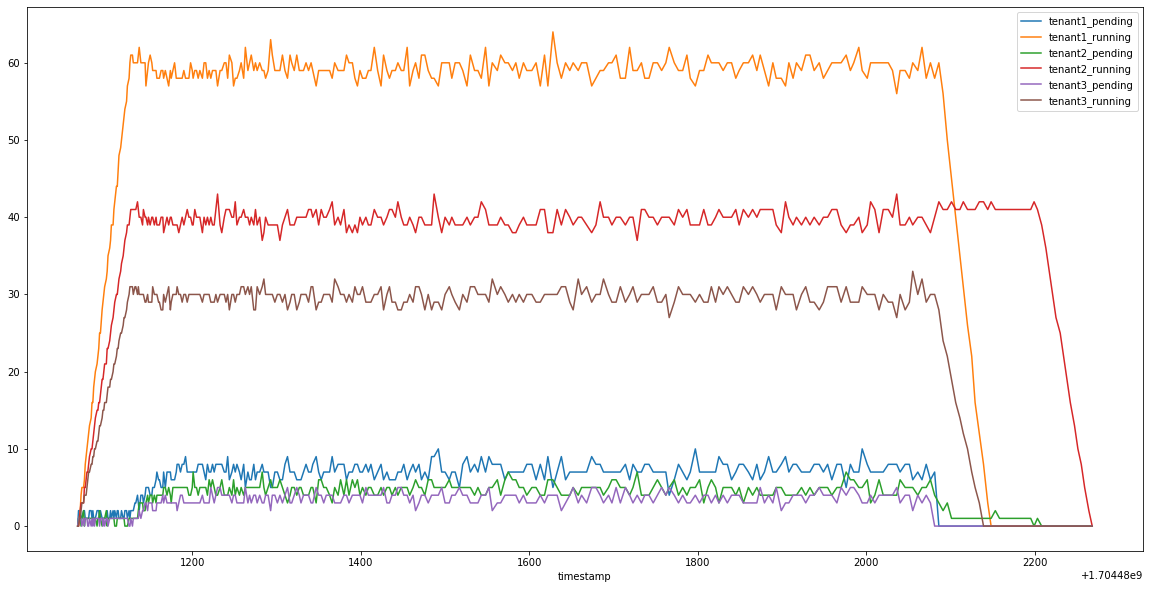

In [10]:
# don't really need to track completed pods
for namespace in namespaces:
    exp_data.pop(namespace+'_completed')

import pandas as pd
pd_data = pd.DataFrame(exp_data)
pd_data.head()
pd_data.plot(x="timestamp", figsize=(20,10))

In [6]:
all_pods = core_api.list_pod_for_all_namespaces()

# filter for pods with "tenant" in the name
all_tenant_pods = [ pod for pod in all_pods.items if "tenant" in pod.metadata.name]
    
    
for namespace in namespaces:
    tenant_pods = [ pod for pod in all_tenant_pods if namespace in pod.metadata.name]
    
    total_queue_time = 0
    total_run_time = 0
    total_time = 0
    
    # start/end used to calculate makespan
    start = None
    end = None
    makespan = 0
    for pod in tenant_pods:
        #print(pod.status.container_statuses[0].state)
        pod_schedule_time = pod.metadata.creation_timestamp

        #pod_start_time = pod.status.start_time
        pod_start_time = pod.status.container_statuses[0].state.terminated.started_at
        pod_end_time = pod.status.container_statuses[0].state.terminated.finished_at
        pod_queue_time = pod_start_time - pod_schedule_time
        pod_run_time = pod_end_time - pod_start_time
        pod_total_time = pod_end_time - pod_schedule_time
        total_queue_time = total_queue_time + int(pod_queue_time.total_seconds())
        total_run_time = total_run_time + int(pod_run_time.total_seconds())
        total_time = total_time + int(pod_total_time.total_seconds())
        # calculate makespan
        if not start or pod_schedule_time < start:
            start = pod_schedule_time
        if not end or pod_end_time > end:
            end = pod_end_time
        #print(pod.metadata.name, pod_start_time, int(pod_queue_time.total_seconds()))
    print(namespace, "Total queue time:", total_queue_time)
    print(namespace, "Average queue time:", total_queue_time / len(tenant_pods))
    print(namespace, "Total run time for all jobs:", total_run_time)
    print(namespace, "Total queue + run time for all jobs:", total_time)
    makespan = end - start
    print(namespace, "Total workflow run time (makespan):", int(makespan.total_seconds()))

tenant1 Total queue time: 545
tenant1 Average queue time: 1.2823529411764707
tenant1 Total run time for all jobs: 25506
tenant1 Total queue + run time for all jobs: 26051
tenant1 Total workflow run time (makespan): 492
tenant2 Total queue time: 429
tenant2 Average queue time: 1.1753424657534246
tenant2 Total run time for all jobs: 21905
tenant2 Total queue + run time for all jobs: 22334
tenant2 Total workflow run time (makespan): 613
tenant3 Total queue time: 275
tenant3 Average queue time: 1.3095238095238095
tenant3 Total run time for all jobs: 12601
tenant3 Total queue + run time for all jobs: 12876
tenant3 Total workflow run time (makespan): 483
